# Costly conversion challenge
---

## Question 
Does increasing the price from 39 USD to 59 USD increases company's revenue?  

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling

from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")


In [ ]:
# load two tables
df_user = pd.read_csv("user_table.csv")
df_test = pd.read_csv("test_results.csv")

In [12]:
# check user table
df_user.profile_report()

In [11]:
# check test table

df_test.profile_report()

In [5]:
print("\n=====================================================")
print("Test Info")
print("=====================================================")
print("Number of unique users {}".format(len(df_test.user_id.unique())))
print("Number of users in test condition = {}, control condition = {}"
      .format(len(df_test[df_test['test']==1]),len(df_test[df_test['test']==0]))) 
print("Number of users converted = {}, not converted = {}"
      .format(len(df_test[df_test['converted']==1]),len(df_test[df_test['converted']==0]))) 
print(df_test.device.unique())
print(df_test.operative_system.unique())
print(df_test.source.unique()) # group adds by seo, ads (how many others, linux?)

print("\n=====================================================")
print("User Info")
print("=====================================================")
print("Number of unique users  = {}".format(len(df_user.user_id.unique())))
print("Number of cities = {}".format(len(df_user.city.unique())))
print("min and max longitude = {}, {}".format(min(df_user.long), max(df_user.long)))
print("min and max latitude = {}, {}".format(min(df_user.lat), max(df_user.lat)))



Test Info
Number of unique users 316800
Number of users in test condition = 114073, control condition = 202727
Number of users converted = 5808, not converted = 310992
['mobile' 'web']
['iOS' 'android' 'mac' 'windows' 'other' 'linux']
['ads_facebook' 'seo-google' 'ads-bing' 'direct_traffic' 'ads-google'
 'seo_facebook' 'friend_referral' 'ads_other' 'ads-yahoo' 'seo-yahoo'
 'seo-bing' 'seo-other']

User Info
Number of unique users  = 275616
Number of cities = 923
min and max longitude = -157.8, 30.31
min and max latitude = 19.7, 61.18


In [6]:
# fix timestamps
timestamps_fixed = []
for x in range(len(df_test)):
    timestamps_fixed.append(df_test.timestamp[x].replace('60','00'))
df_test['timestamps_fixed'] = timestamps_fixed
df_test['timestamps_fixed'] = pd.to_datetime(df_test['timestamps_fixed'])
df_test['timestamps_fixed'] = df_test['timestamps_fixed'].dt.date

In [7]:
print("test\n{}".format(df_test.price[df_test["test"]==1].value_counts()))
print("control\n{}".format(df_test.price[df_test["test"]==0].value_counts()))

test
59    113918
39       155
Name: price, dtype: int64
control
39    202517
59       210
Name: price, dtype: int64


In [8]:
# reasign to the correct group
#df_test.loc[df_test.price == 39, ['test']] = 0
#df_test.loc[df_test.price == 59, ['test']] = 1
# or drop events with conflicting information, since we dont know where the mistake is coming from
df_test = df_test.drop(df_test[(df_test.price == 39) & (df_test.test == 1)].index)
df_test = df_test.drop(df_test[(df_test.price == 59) & (df_test.test == 0)].index).reset_index()

In [9]:
print("test\n{}".format(df_test.price[df_test["test"]==1].value_counts()))
print("control\n{}".format(df_test.price[df_test["test"]==0].value_counts()))

test
59    113918
Name: price, dtype: int64
control
39    202517
Name: price, dtype: int64


## Plot data

<Figure size 1440x720 with 0 Axes>

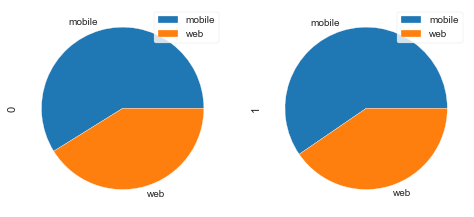

In [53]:
# device
plt.figure(figsize = (20,10))
df_test.groupby('device')['converted'].value_counts().unstack().plot(kind = 'pie', subplots=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a2bfbcc50>,
      dtype=object)

<Figure size 1440x720 with 0 Axes>

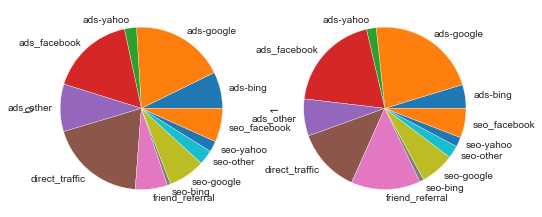

In [59]:
# source
plt.figure(figsize = (20,10))
df_test.groupby('source')['converted'].value_counts().unstack().plot(kind = 'pie', subplots=True, legend = False)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a1cb75850>,
      dtype=object)

<Figure size 1440x720 with 0 Axes>

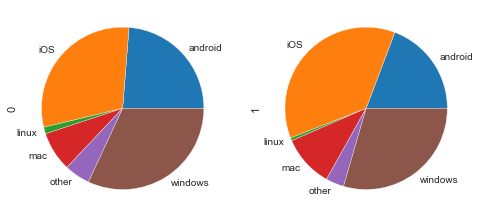

In [60]:
# System
plt.figure(figsize = (20,10))
df_test.groupby('operative_system')['converted'].value_counts().unstack().plot(kind = 'pie', subplots=True, legend = False)


## Stats

In [61]:
# split into exper and control groups, and calculate daily means
exper = df_test[df_test['test']==1]
control = df_test[df_test['test']==0]
exper_mean = exper[['converted','timestamps_fixed']].groupby('timestamps_fixed').mean().reset_index()
control_mean = control[['converted','timestamps_fixed']].groupby('timestamps_fixed').mean().reset_index()

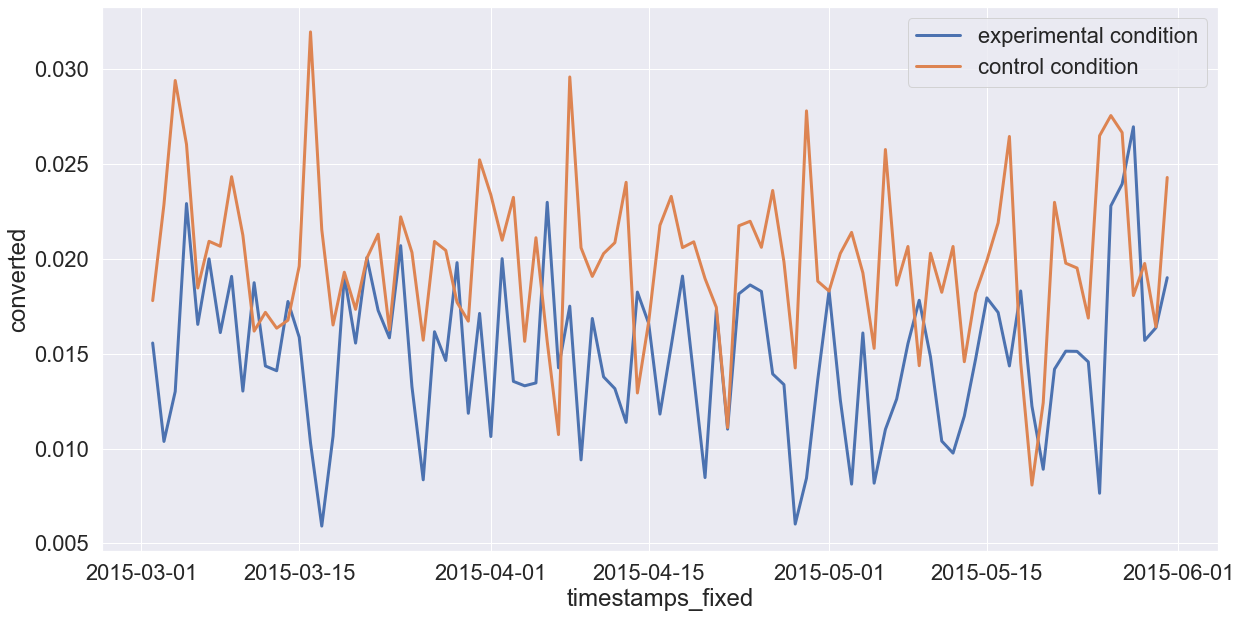

In [62]:
import seaborn as sns
sns.set(font_scale = 2)
plt.figure(figsize=(20,10))
ax = sns.lineplot(x = 'timestamps_fixed', y = 'converted', data = exper_mean, label = 'experimental condition', lw = 3)
ax = sns.lineplot(x = 'timestamps_fixed', y = 'converted', data = control_mean, label = 'control condition', lw = 3)


In [66]:
control['rev'] = control['converted'] * control['price']
exper['rev'] = exper['converted'] * exper['price']
print('\n Control revenue = {} USD \n Experimental revenue = {} USD'
     .format(control.rev.sum(), exper.rev.sum()))


 Control revenue = 157170.0 USD 
 Experimental revenue = 104548.0 USD


[Text(0, 0.5, 'total revenue'), Text(0.5, 0, 'condition')]

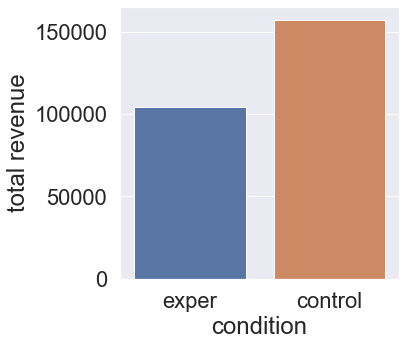

In [67]:
plt.figure(figsize = (5,5))
ax = sns.barplot(['exper','control'],[exper.rev.sum(), control.rev.sum()])
ax.set(xlabel = 'condition', ylabel = 'total revenue')

[Text(0, 0.5, 'days'), Text(0.5, 0, 'rate of conversion')]

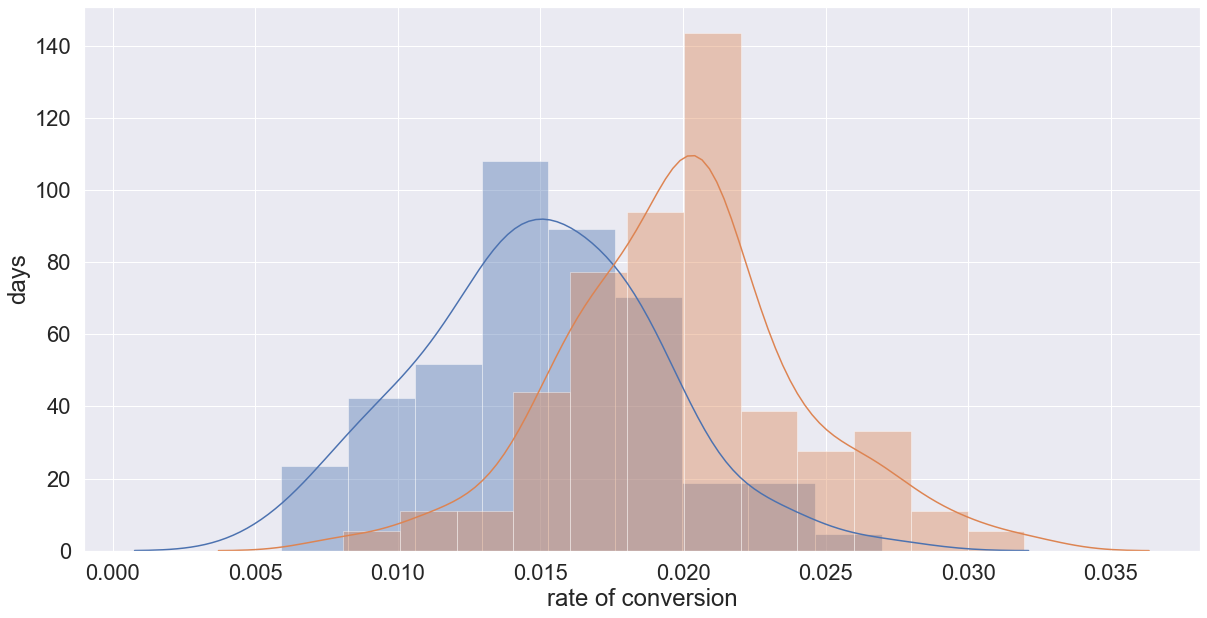

In [68]:
plt.figure(figsize = (20,10))
ax = sns.distplot(exper_mean.converted)
ax = sns.distplot(control_mean.converted)
ax.set(xlabel = 'rate of conversion', ylabel = 'days')

In [69]:
from scipy.stats import ttest_ind as ttest
stats, p_value = ttest(exper_mean.converted, control_mean.converted)
print('====================\n t-stat = {}, p = {} \n===================='
      .format(round(stats,2), p_value))

 t-stat = -8.15, p = 5.908115585460847e-14 


### Conclusion
Users in control group were more likely to purchase software than users in experimental group.

### Suggestion
Raising the price does not increase revenue or customer convertion rate, thus the company should keep lower price


In [ ]:
import sqlite3
conn = sqlite3.connect(':memory:')
df_test.to_sql('test', conn, index='False')

In [ ]:
qry = '''
SELECT user_id, converted, timestamp FROM test
ORDER BY timestamp DESC;
'''

In [ ]:
df = pd.read_sql(qry,conn)

In [ ]:
from bokeh.plotting import figure, output_notebook, show
import bokeh.io
bokeh.io.reset_output()
bokeh.io.output_notebook()